# The HTRC extracted feature data

Ok, so - the history of "literature." As a starting point, I decided to do experiment with the Hathi Trust "extracted features" data set, which is attractive in this context for a couple of reasons. First, it's huge - just shy of 5M volumes, and, in theory, we could eventually get our hands on the other ~10M volumes at Illinois. Second, it's a broad mix of texts - it's essentially a huge digital bookshelf hauled in out of the stacks in the library - fiction, nonfiction, periodicals, reference texts, everything under the sun. I think this is good for this project, since, in a sense, just looking at the word "literature" _in_ literature would arguably box us into a very particular type of usage - the text-within-the-text, literature thinking about itself. Which could be interesting in and of itself, but possibly not a great place to start for a general treatment of the question.

The Hathi data looks like this, cropped down for readability:

```json
{
  "id": "aeu.ark:/13960/t0000d036",
  "metadata": {
    "pubDate": "1878",
    "handleUrl": "http://hdl.handle.net/2027/aeu.ark:/13960/t0000d036",
    "language": "eng",
    "imprint": "[s.n.], 1878.",
    "htBibUrl": "http://catalog.hathitrust.org/api/volumes/full/htid/aeu.ark:/13960/t0000d036.json",
    "oclc": "716097827",
    "schemaVersion": "1.2",
    "dateCreated": "2015-02-12T20:51",
    "title": "Amphioxus and Ascidian our gelatinous ancestors"
  },
  "features": {
    "pageCount": 6,
    "pages": [
      {
        "tokenCount": 312,
        "body": {
          "tokenPosCount": {
            "presence": {
              "NN": 1
            },
            "kind": {
              "NN": 1
            },
            "investigations": {
              "NNS": 1
            },
            "vertebraie": {
              "NN": 1
            },
            "wise": {
              "JJ": 1
            },
            "series": {
              "NN": 1
            },
            "the": {
              "DT": 10
            },
            "Vertebrata": {
              "NNP": 1
            },

            // more words...
            
          },
          "tokenCount": 312,
          "emptyLineCount": 20,
          "sentenceCount": 15,
          "lineCount": 66
        },
        "emptyLineCount": 20,
        "sentenceCount": 15,
        "lineCount": 66
      },
      
      // more pages...
      
    ],
    "schemaVersion": "2.0",
    "dateCreated": "2015-02-19T17:21"
  }
}

```

Basically - simple bibliographic metadata about the volume, and then per-page token counts, broken out by page section and part-of-speech. I actually think that the "page" is a nice unit of study for this projet, in a lot of ways. As discussed at the Concept Lab meeting this week - this scale is a nice middle-ground between the tight scope of the "sentence" or "phrase," the unit of analysis for the traditional notion of colocation in corpus linguistics, and the broader notion of the "document," as used in bag-of-words paradigms like topic modeling or information retrieval. It's a small constituent part of a text, but still big enough to lasso a meaningful swath of semantic information.

## Data wrangling

So, where to start? To say anything meaningful about changes in word frequencies over time around "literature," we have to be able to compare against the baseline changes in volume over time, or else we'd almost certainly just be picking up on these overall trends. Eg - words like "thou" or "magick" show up much less frequently around literature over time in an absolute sense, but this is just because they become generally less prevalent, not because of any real change in the conceptual attraction of the words.

What we need, then, is per-year token counts for each unique token in the corpus. This is simple in concept - just loop through the volumes and build up a big `year -> token -> count` map. But in practice, because of the size of the Hathi data, this gets complicated, especially if we want to write code that will scale up to the complete data set. After a bit of experimentation, here's the flow I settled on:

- Loop through the volume paths in groups of 5-10k. For each successive group, use Python's `multiprocessing` module to spawn off a pool of workers that process the paths in parallel - inflate the `.bz2`, make a `Volume` instance, and return a cleaned `token -> count` map for the volume. Since reading the files is heavy IO, the parallelization gives a huge speedup.


- As these results come back to the controller process, build up an in-memory cache of the `year -> token -> count` totals.


- Only when all the paths in the group have been processed, flush the cached counts into Postgres using the new `UPSERT` syntax in 9.5, which makes it possible to increment each of the year + token counters with a single query.


- Empty the cache, repeat with the next group of paths.

Why the "groups", instead of just processing and indexing each volume individually? This has the effect of bundling together the increment queries, which reduces the number of times we have to go across the wire to Postgres. Eg, say three volumes produce these token/year/count triples:

```
("literature", 1900, 10)
("literature", 1900, 20)
("literature", 1900, 30)
```

Instead of running three separate queries, by building up the temporary caches in-memory these get merged into a single update that has the same effect:

```
("literature", 1900, 60)
```

But, since we flush the cache after each ~10k volumes, we never build up too much memory pressure on the machine.

## Counting words

The word counts are accessed via `CountQueries`, a set of utilities that runs queries against the underlying `Count` class, a SQLAlchemy model.

In [1]:
from htrc.queries import CountQueries

counts = CountQueries()

years = counts.years()
print('{0} total years'.format(len(years)))
print(years[:50])

395 total years
[882, 918, 1191, 1527, 1550, 1559, 1570, 1572, 1575, 1579, 1580, 1583, 1589, 1590, 1591, 1592, 1593, 1594, 1595, 1597, 1599, 1600, 1601, 1602, 1603, 1604, 1605, 1606, 1607, 1609, 1610, 1611, 1612, 1613, 1614, 1618, 1619, 1622, 1623, 1624, 1625, 1626, 1627, 1628, 1630, 1632, 1633, 1634, 1635, 1636]


To get a sorted list of unique tokens (so we can iterate over all observed words):

In [2]:
tokens = counts.tokens()
print('{0} total word types'.format(len(tokens)))
print(tokens[:50])

9408 total word types
['a', 'aa', 'aah', 'aaron', 'ab', 'abandon', 'abandoned', 'abbey', 'abc', 'abilities', 'ability', 'able', 'abnormal', 'aboard', 'abortion', 'about', 'above', 'abraham', 'abroad', 'absence', 'absent', 'absolute', 'absolutely', 'absorbed', 'absorption', 'abstract', 'absurd', 'abu', 'abundance', 'abundant', 'abuse', 'abused', 'ac', 'academic', 'academy', 'acc', 'accent', 'accept', 'acceptable', 'acceptance', 'accepted', 'accepting', 'accepts', 'access', 'accessed', 'accessible', 'accessories', 'accident', 'accidentally', 'accidents']


Now, the count data. In total, we've seen about 5.6 billion individual tokens:

In [3]:
total = 0
for year in years:
    total += counts.year_count(year)
    
print(total)

5660168695


To get the total number of tokens observed in a given year:

In [4]:
counts.year_count(1912)

84661673

And, to get the number of times that one particular token appeared in a year:

In [5]:
counts.token_year_count('literature', 1912)

5496

This gives us what we need for aggregate time-series plots. Here's total volume by year:

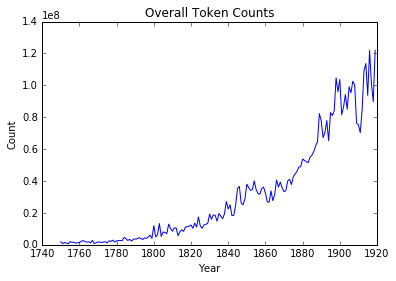

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

xs = range(1750, 1920)

ys = []
for year in xs:
    ys.append(counts.year_count(year))
    
plt.title('Overall Token Counts')
plt.xlabel('Year')
plt.ylabel('Count')
plt.plot(xs, ys)

Or, for an individual token:

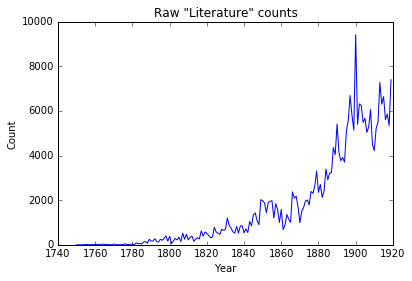

In [7]:
ys = []
for year in xs:
    ys.append(counts.token_year_count('literature', year))
    
plt.title('Raw "Literature" counts')
plt.xlabel('Year')
plt.ylabel('Count')
plt.plot(xs, ys)

These will obviously correlate strongly with the overall volume. More useful is words-per-million:

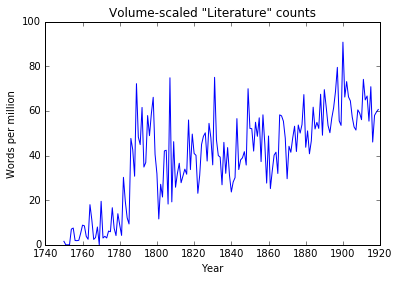

In [8]:
ys = counts.token_year_wpm_series('literature', xs)
    
plt.title('Volume-scaled "Literature" counts')
plt.xlabel('Year')
plt.ylabel('Words per million')
plt.plot(xs, ys)

Or, smoothed out using a 5-year rolling average:

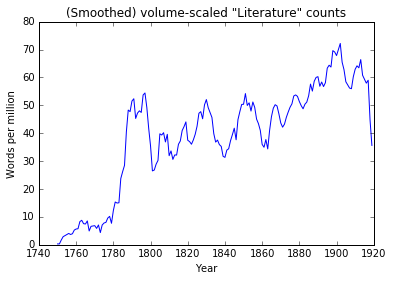

In [9]:
ys = counts.token_year_wpm_series_smooth('literature', xs)

plt.title('(Smoothed) volume-scaled "Literature" counts')
plt.xlabel('Year')
plt.ylabel('Words per million')
plt.plot(xs, ys)

## Rolling correlations

Alright, so, we can plot words, just like [Hathi's Bookworm tool](https://bookworm.htrc.illinois.edu/) or the Google ngram viewer. But, let's get back to the question - how has "literature" changed over time? This gives us a simplest possible set of answers, in a sense - its frequency hasn't been static, it was more salient in 1790 than in 1800, etc.

But, limited as this is, it may actually give access to something a bit richer. Back in 2011, [Ted Underwood found](http://tedunderwood.com/2011/11/18/exploring-the-relationship-between-topics-and-trends), somewhat surprisingly, that correlations between the diachronic frequencies of words are, in turn, very strongly correlated with their rates of co-occurrence in the same volumes. That's to say - if two words share a similar frequency trend, then it's very likely that they're also showing up together in the same texts.

Which is closer to what we actually care about - what's _around_ literature, its siblings, its neighbors, its semantic context. How has this shifted over time? Are there words that have "approached" literature, words that have "departed" from it? Here's where the relationship between frequency correlation and co-occurrence comes in handy. If we assume that the one proxies the other - what if we just looked for words that have a significantly _dynamic_ correlation with literature over time? Eg, words that are very tightly correlated for a centry or so, but then drift away, or vice versa. Or words that are generally un-correlated, but for some reason have a brief flash of high correlation, only then to move away again.

For example, take "literature" vs. "poetry":

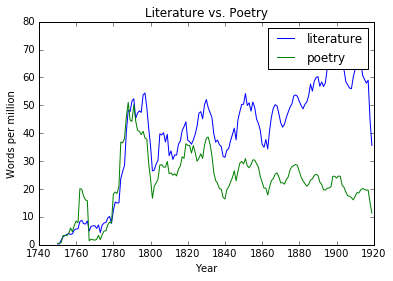

In [10]:
literature = counts.token_year_wpm_series_smooth('literature', xs)
poetry = counts.token_year_wpm_series_smooth('poetry', xs)

plt.title('Literature vs. Poetry')
plt.xlabel('Year')
plt.ylabel('Words per million')
plt.plot(xs, literature, label='literature')
plt.plot(xs, poetry, label='poetry')
plt.legend(loc='upper right')

Poetry seems to hang with literature very tightly from 1750 to around 1860, but then starts to gradually drift down, while literature continues to increase. We can compute the overall Pearson correlation between the two time series:

In [11]:
from scipy import stats

corr, p = stats.pearsonr(literature, poetry)
print(corr, p)

0.593782100589 1.41329221507e-17


More to the point - we can also slide a window across the X-axis and compute a rolling correlation:

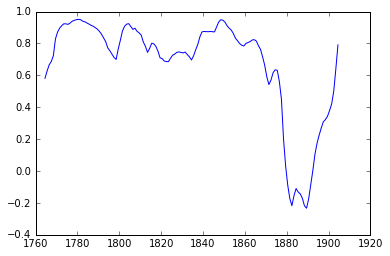

In [14]:
years = range(1750, 1920)
xs, ys = counts.rolling_correlation('literature', 'poetry', years)

plt.plot(xs, ys)